# UPC Quantum Engineering Final Project: Quantum Channel Discrimination
## II. One-shot discrimination Base circuit

In [5]:
# Enabling the `widget` backend.print(totalFinalStates[1][zero_amplitude])
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib inline

from itertools import product, combinations
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
from qiskit.providers.aer import noise
from qiskit.quantum_info import Operator, average_gate_fidelity, state_fidelity

from numpy import pi
from math import e
from matplotlib import colors, cm
from matplotlib.ticker import PercentFormatter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter)

import matplotlib.pyplot as plt
import numpy as np
import math

# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

## Functions definition

In [6]:
def prepareInitialStates(inAnglesTheta, inAnglesPhase):
    """ Prepare initial states to pass through the circuit """
    # As we have to provide the state values to initialize the qreg[0] we have to do a conversion
    # from angles in the sphere to statevector amplitudes. These statevectors will be the combination of
    # Zero_Amplitude*|0> plus One_Amplitude*|1>
    initialStatesZeroAmplitude = []
    initialStatesOneAmplitude = []

    for theta in inAnglesTheta:
        for phase in inAnglesPhase:
            initialStatesZeroAmplitude.append(math.cos(theta/2)*(1+0j))
            initialStatesOneAmplitude.append((math.sin(theta/2)*e**(1j*phase)+0+0j))
    # List of Initial States
            # print("State ", indexTheta*P+indexPhase," =", initialStatesZeroAmplitude[indexTheta*P+indexPhase],"*|0> + ", initialStatesOneAmplitude     [indexTheta*P   +indexPhase], "*|1>")
    return {
        "zeroAmplitude": initialStatesZeroAmplitude,
        "oneAmplitude": initialStatesOneAmplitude,
    }

In [7]:
def convertCountsToFinalState(inCounts):
    """ Convert the results of a simulation to a final state: aplha*|0> + beta*|1> """
    countsZero = 0
    countsOne = 0

    if "0" in inCounts:
        countsZero = inCounts["0"]
    if "1" in inCounts:
        countsOne = inCounts["1"]

    totalCycles = countsZero + countsOne
    
    return {
        "zeroAmplitude": np.sqrt(countsZero/totalCycles),
        "oneAmplitude": np.sqrt(countsOne/totalCycles),
    }

In [8]:
def computeStateVectorCoordsReshaped(amplitudesVector, inputAnglesPhase, nPointsTheta, nPointsPhase):
    """ Compute the reshaped coordinates from a given amplitudes """
    initialStateVectorCoordsX = []
    initialStateVectorCoordsY = []
    initialStateVectorCoordsZ = []
    for indexAmplitudes in range(len(amplitudesVector)):
        Theta_i = 2*np.arccos(amplitudesVector[indexAmplitudes])
        Phase_i = inputAnglesPhase[indexAmplitudes % nPointsPhase]
        initialStateVectorCoordsX.append(np.sin(Theta_i)*np.cos(Phase_i))
        initialStateVectorCoordsY.append(np.sin(Theta_i)*np.sin(Phase_i))
        initialStateVectorCoordsZ.append(np.cos(Theta_i))
    # Reshaping matrices X, Y and Z in right dimensions to be represented
    return {
        'reshapedCoordsX':  np.reshape(initialStateVectorCoordsX, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsY':  np.reshape(initialStateVectorCoordsY, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsZ':  np.reshape(initialStateVectorCoordsZ, (nPointsTheta, nPointsPhase)),
    }

In [9]:
def computeFinaleStateVectorCoordsReshaped(amplitudesVector, inputAnglesPhase, nPointsTheta, nPointsPhase):
    """ Compute the final state reshaped coordinates from a given amplitudes """
    finalStateVectorCoordsX = []
    finalStateVectorCoordsY = []
    finalStateVectorCoordsZ = []
    for indexAmplitudes in range(len(amplitudesVector)):
        Theta_i = 2*np.arccos(amplitudesVector[indexAmplitudes])
        Phase_i = inputAnglesPhase[indexAmplitudes % nPointsPhase]
        finalStateVectorCoordsZ.append(np.cos(Theta_i))
    # Reshaping matrices X, Y and Z in right dimensions to be represented
    top_z = max(finalStateVectorCoordsZ)
    min_z = min(finalStateVectorCoordsZ)
    radius = (top_z-min_z)/2
    center_z = 1-radius

    for newIndexAmplitudes in range(len(amplitudesVector)):
        newTheta_i = np.arccos((finalStateVectorCoordsZ[newIndexAmplitudes]-center_z)/radius)
        newPhase_i = inputAnglesPhase[newIndexAmplitudes % nPointsPhase]
        finalStateVectorCoordsX.append(np.sqrt(radius)*np.sin(newTheta_i)*np.cos(newPhase_i))
        finalStateVectorCoordsY.append(np.sqrt(radius)*np.sin(newTheta_i)*np.sin(newPhase_i))
    return {
        'reshapedCoordsX':  np.reshape(finalStateVectorCoordsX, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsY':  np.reshape(finalStateVectorCoordsY, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsZ':  np.reshape(finalStateVectorCoordsZ, (nPointsTheta, nPointsPhase)),
        'center': center_z
    }

In [10]:
def draw_cube(axes):
    """ Draw a cube passing axes as a parameter """
    r = [-1, 1]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s-e)) == r[1]-r[0]:
            axes.plot3D(*zip(s, e), color="w")

## Circuit definition and computation

In [11]:
def runDampingChannelSimulation(anglesEta, pointsTheta, pointsPhase, iterations, backend):
    # Create 2 qbits circuit and 1 output classical bit
    qreg_q = QuantumRegister(2, 'q')
    creg_c = ClassicalRegister(1, 'c')
    # First we generate the angles which will help the draw the sphere
    anglesTheta = np.mgrid[0:pi:pointsTheta*1j]
    anglesPhase = np.mgrid[0:2*pi:pointsPhase*1j]

    totalResults = []
    totalCounts = []
    totalCircuits = []
    totalFinalStates = []

    Z_Output0 = []
    Z_Output1 = []
    X_Input0 = []
    X_Input1 = []
    Y_Eta = []
    
    initialStates = prepareInitialStates(anglesTheta, anglesPhase)

    # Initialize circuit with desired initial_state
    for eta in anglesEta:
        print("Simulating channel with " + u"\u03B7" + " = " + str(int(math.degrees(eta)))  + u"\u00B0")
        circuitResultsSpecificChannel = []
        countsSpecificChannel = []
        circuitSpecificChannel = []
        finalStates = {
            "zeroAmplitude": [],
            "oneAmplitude": [],
        }
        
        nested_Z_Output0 = []
        nested_Z_Output1 = []
        nested_X_Input0 = []
        nested_X_Input1 = []
        nested_Y_Eta = []
        Z_Output0.append(nested_Z_Output0)
        Z_Output1.append(nested_Z_Output1)
        X_Input0.append(nested_X_Input0)
        X_Input1.append(nested_X_Input1)
        Y_Eta.append(nested_Y_Eta)
        loop_counter = 0
        
        for indexInitialState in range(len(initialStates["zeroAmplitude"])):
                phase_cycle=indexInitialState//(len(anglesPhase)*len(anglesTheta))
                if loop_counter < phase_cycle:
                    loop_counter = phase_cycle
                    nested_Z_Output0 = []
                    nested_Z_Output1 = []
                    nested_X_Input0 = []
                    nested_X_Input1 = []
                    nested_Y_Eta = []
                    
                circuit = QuantumCircuit(qreg_q, creg_c)
                circuit.initialize([initialStates["zeroAmplitude"][indexInitialState], initialStates["oneAmplitude"][indexInitialState]], qreg_q[0])
                circuit.reset(qreg_q[1])
                circuit.cry(eta, qreg_q[0], qreg_q[1])
                circuit.cx(qreg_q[1], qreg_q[0])
                circuit.measure(qreg_q[0], creg_c[0])
                circuitSpecificChannel.append(circuit)
                # execute circuit on backends
                job_sim = execute(circuit, backend, shots=iterations)
                # get results
                results_sim = job_sim.result()
                circuitResultsSpecificChannel.append(results_sim)
                counts = results_sim.get_counts(circuit)
                countsSpecificChannel.append(counts)
                finalState = convertCountsToFinalState(counts)
                finalStates["zeroAmplitude"].append(finalState["zeroAmplitude"])
                finalStates["oneAmplitude"].append(finalState["oneAmplitude"])
                nested_Z_Output0.append(finalState["zeroAmplitude"]**2)
                nested_Z_Output1.append(finalState["oneAmplitude"]**2)
                Prob_0 = initialStates["zeroAmplitude"][indexInitialState]*np.conj(initialStates["zeroAmplitude"][indexInitialState])
                Prob_1 = initialStates["oneAmplitude"][indexInitialState]*np.conj(initialStates["oneAmplitude"][indexInitialState])
                nested_X_Input0.append(Prob_0.real)
                nested_X_Input1.append(Prob_1.real)
                nested_Y_Eta.append(eta)
            
            # append the results for a specific channel
        totalCircuits.append(circuitSpecificChannel)
        totalFinalStates.append(finalStates)
        totalCounts.append(countsSpecificChannel)
        totalResults.append(circuitResultsSpecificChannel)

    return {
        "initialStates": initialStates,
        "totalCircuits": totalCircuits,
        "totalFinalStates": totalFinalStates,
        "totalCounts": totalCounts,
        "totalResults": totalResults,
        "anglesPhase": anglesPhase,
        "Z_Output0": np.array(Z_Output0),
        "Z_Output1": np.array(Z_Output1),
        "X_Input0": np.array(X_Input0),
        "X_Input1": np.array(X_Input1),
        "Y_Eta": np.array(Y_Eta)
    }


In [12]:
#print(initialStates["oneAmplitude"])

In [13]:
pointsTheta = 20  # Points of Theta angle (pi) in Bloch sphere - min 2
pointsPhase = 10  # Points of Phase angle (2*pi) in Bloch sphere - min 2
# angles shift from first parameter, to the second one, with jumps using the third parameter
anglesEta = np.arange(0, pi, 2*pi/(pointsTheta*pointsPhase))
# anglesEta = [0, pi/4, pi/1.5, pi/1.09]
simulatedResult = runDampingChannelSimulation(anglesEta=anglesEta , pointsTheta=pointsTheta, pointsPhase=pointsPhase, iterations=1024, backend=backend_sim)
initialStates = simulatedResult["initialStates"]
totalResults = simulatedResult["totalResults"]
totalCounts = simulatedResult["totalCounts"]
totalCircuits = simulatedResult["totalCircuits"]
totalFinalStates = simulatedResult["totalFinalStates"]
anglesPhase = simulatedResult["anglesPhase"]
Z_Output0 = simulatedResult["Z_Output0"]
Z_Output1 = simulatedResult["Z_Output1"] 
X_Input0 = simulatedResult["X_Input0"]
X_Input1 = simulatedResult["X_Input1"]
Y_Eta = simulatedResult["Y_Eta"] 

# Set the Initial States
initialStatesReshaped = computeStateVectorCoordsReshaped(initialStates["zeroAmplitude"], anglesPhase, pointsTheta, pointsPhase)
# Set the Final States
allChannelsFinalStatesReshaped = []
for indexFinalState in range(len(totalFinalStates)):
    singleChannelFinalStatesReshaped = computeFinaleStateVectorCoordsReshaped(totalFinalStates[indexFinalState]["zeroAmplitude"], anglesPhase, pointsTheta, pointsPhase)
    allChannelsFinalStatesReshaped.append(singleChannelFinalStatesReshaped)

Simulating channel with η = 0°
Simulating channel with η = 1°
Simulating channel with η = 3°
Simulating channel with η = 5°
Simulating channel with η = 7°
Simulating channel with η = 9°
Simulating channel with η = 10°
Simulating channel with η = 12°
Simulating channel with η = 14°
Simulating channel with η = 16°
Simulating channel with η = 18°
Simulating channel with η = 19°
Simulating channel with η = 21°
Simulating channel with η = 23°
Simulating channel with η = 25°
Simulating channel with η = 27°
Simulating channel with η = 28°
Simulating channel with η = 30°
Simulating channel with η = 32°
Simulating channel with η = 34°
Simulating channel with η = 36°
Simulating channel with η = 37°
Simulating channel with η = 39°
Simulating channel with η = 41°
Simulating channel with η = 43°
Simulating channel with η = 45°
Simulating channel with η = 46°
Simulating channel with η = 48°
Simulating channel with η = 50°
Simulating channel with η = 52°
Simulating channel with η = 54°
Simulating cha

In [14]:
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ
# provider = IBMQ.load_account()
# Load IBM Q account and get the least busy backend device
# least_busy_device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2, simulator=False))
# print("Running on current least busy device: ", least_busy_device)

In [15]:
# pointsTheta = 4  # Points of Theta angle (pi) in Bloch sphere - min 2
# pointsPhase = 4  # Points of Phase angle (2*pi) in Bloch sphere - min 2
# angles shift from first parameter, to the second one, with jumps using the third parameter
# anglesEta = np.arange(0, 2*pi, 2*pi/6)
# anglesEta = [pi/1.5]
# realResult = runDampingChannelSimulation(anglesEta=anglesEta , pointsTheta=pointsTheta, pointsPhase=pointsPhase, iterations=1024, backend=least_busy_device)
# initialStates = realResult["initialStates"]
# totalResults = realResult["totalResults"]
# totalCounts = realResult["totalCounts"]
# totalCircuits = realResult["totalCircuits"]
# totalFinalStates = realResult["totalFinalStates"]

In [16]:
# Set the Initial States
initialStatesReshaped = computeStateVectorCoordsReshaped(initialStates["zeroAmplitude"], anglesPhase, pointsTheta, pointsPhase)
# Set the Final States
allChannelsFinalStatesReshaped = []
for indexFinalState in range(len(totalFinalStates)):
    singleChannelFinalStatesReshaped = computeFinaleStateVectorCoordsReshaped(totalFinalStates[indexFinalState]["zeroAmplitude"], anglesPhase, pointsTheta, pointsPhase)
    allChannelsFinalStatesReshaped.append(singleChannelFinalStatesReshaped)


## Plotting the results

### Damping channel for $\eta=\pi/4$

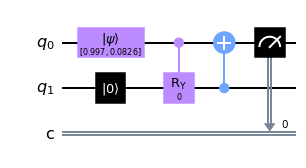

In [17]:
totalCircuits[0][10].draw('mpl')

### Input vs Output Probabilities (WIP)

In [18]:
def probability_from_amplitude(amplitude) -> int:
    return np.round(np.linalg.norm(amplitude) ** 2, 2)

In [19]:
def extract_amplitudes_states(initial_states, final_states, number_execution, output_probabilities):
    total_amplitudes_to_extract = 20
    initial_state_zero_amplitude = "input_0"
    initial_state_one_amplitude = "input_1"
    final_state_zero_amplitude = "output_0"
    final_state_one_amplitude = "output_1"
    zero_amplitude = "zeroAmplitude"
    one_amplitude = "oneAmplitude"
    
    output_probabilities.append({ 
        initial_state_zero_amplitude: probability_from_amplitude(initial_states[zero_amplitude][0]),
        final_state_zero_amplitude: probability_from_amplitude(final_states[number_execution][zero_amplitude][0]),
        initial_state_one_amplitude: probability_from_amplitude(initial_states[one_amplitude][0]),
        final_state_one_amplitude: probability_from_amplitude(final_states[number_execution][one_amplitude][0])
    })

    for index in range(2,total_amplitudes_to_extract):
        index_state = int((len(final_states[number_execution][zero_amplitude])/total_amplitudes_to_extract)*index)
        output_probabilities.append({ 
            initial_state_zero_amplitude: probability_from_amplitude(initial_states[zero_amplitude][index_state]),
            final_state_zero_amplitude: probability_from_amplitude(final_states[number_execution][zero_amplitude][index_state]),
            initial_state_one_amplitude: probability_from_amplitude(initial_states[one_amplitude][index_state]),
            final_state_one_amplitude: probability_from_amplitude(final_states[number_execution][one_amplitude][index_state])
        })
    
    final_index_state = int((len(final_states[number_execution][zero_amplitude])/total_amplitudes_to_extract)*total_amplitudes_to_extract)-1
    output_probabilities.append({ 
        initial_state_zero_amplitude: probability_from_amplitude(initial_states[zero_amplitude][final_index_state]),
        final_state_zero_amplitude: probability_from_amplitude(final_states[number_execution][zero_amplitude][final_index_state]),
        initial_state_one_amplitude: probability_from_amplitude(initial_states[one_amplitude][final_index_state]),
        final_state_one_amplitude: probability_from_amplitude(final_states[number_execution][one_amplitude][final_index_state])
    })
    return output_probabilities

In [20]:
def plot_probabilities(input_0, input_1, output_0, output_1, index_angle): 
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, tight_layout=True)

    axs[0][0].bar(range(len(input_0)), input_0, color="orange")
    # axs[0][0].set_title("Input " + "$\\alpha|0\\rangle$")
    axs[0][0].set_xlabel("Input " + "$\\alpha|0\\rangle$")
    axs[0][0].set_ylabel("Probabilities")
    axs[0][1].bar(range(len(input_1)), input_1, color="orange")
    # axs[0][1].set_title("Input " + "$\\beta|1\\rangle$")
    axs[0][1].set_xlabel("Input " + "$\\beta|1\\rangle$")
    axs[1][0].bar(range(len(output_0)), output_0)
    # axs[1][0].set_title("Output " + "$\\alpha|0\\rangle$")
    axs[1][0].set_xlabel("Output " + "$\\alpha|0\\rangle$")
    axs[1][0].set_ylabel("Probabilities")
    axs[1][1].bar(range(len(output_1)), output_1)
    # axs[1][1].set_title("Output " + "$\\beta|1\\rangle$")
    axs[1][1].set_xlabel("Output " + "$\\beta|1\\rangle$")

    for row_i in range(len(axs)):
        for col_j in range(len(axs[row_i])):
            for label in axs[row_i][col_j].get_xaxis().get_ticklabels():
                label.set_visible(False)

    fig.suptitle("Probabilities Input vs Output Channel " + "$\eta=" + str(int(math.degrees(anglesEta[index_angle]))) + "\degree$")
    fig.set_size_inches(7,5)

    display(plt.show())


In [21]:
def prepare_and_plot_probabilities(anglesEta, initialStates, totalFinalStates):
    # extract just a sample of all the computed probabilities
    total_output_probabilities = []
    for indexCountsToPrint in range(len(anglesEta)):
        output_probabilities = []
        output_probabilities = extract_amplitudes_states(initialStates, totalFinalStates, indexCountsToPrint, output_probabilities)
        total_output_probabilities.append(output_probabilities)
    final_probabilities = []
    # prepare data to be plotted as bars
    for index in range(len(total_output_probabilities)):
        input_0 = []
        input_1 = []
        output_0 = []
        output_1 = []
        for prob_i in total_output_probabilities[index]:
            input_0.append(prob_i["input_0"])
            input_1.append(prob_i["input_1"])
            output_0.append(prob_i["output_0"])
            output_1.append(prob_i["output_1"])
        final_probabilities.append({
            "input_0": input_0, 
            "input_1": input_1,
            "output_0": output_0,
            "output_1": output_1,
        })
    for index in range(len(final_probabilities)):
        plot_probabilities(final_probabilities[index]["input_0"], final_probabilities[index]["input_1"], final_probabilities[index]["output_0"], final_probabilities[index]["output_1"], index)


In [22]:
# prepare_and_plot_probabilities(anglesEta, initialStates, totalFinalStates)

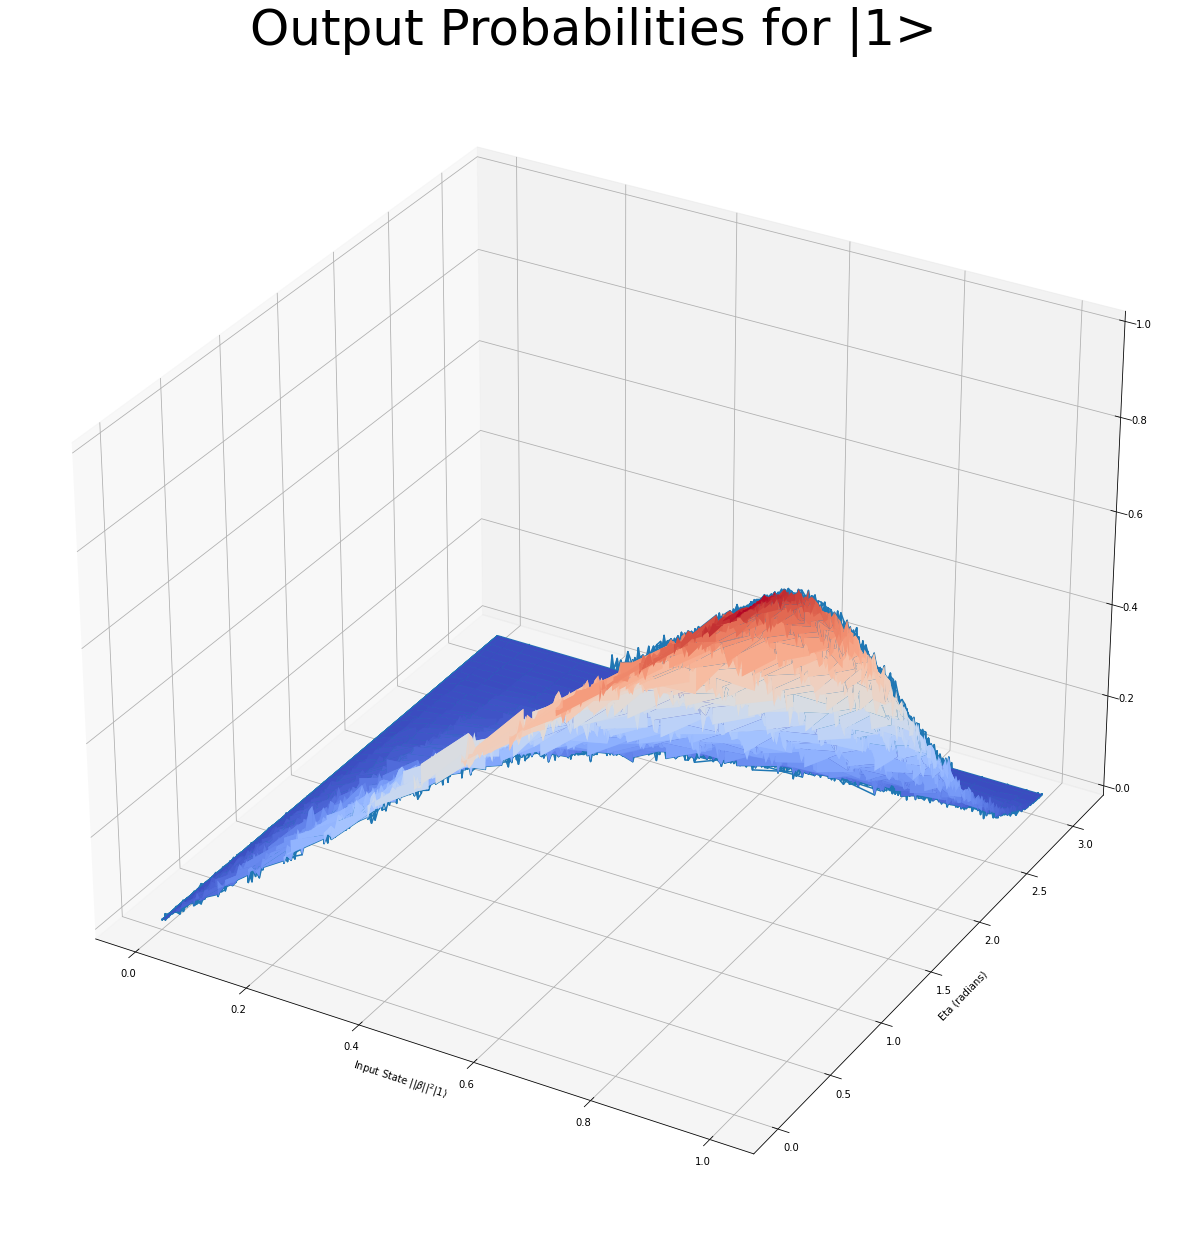

In [23]:
#Representation of output probabilities for all circuit in a 3d plot
fig = plt.figure(figsize=(100,125))
ax = fig.add_subplot(5,4,1, projection='3d')

#ax.plot_wireframe(X_Input0, Y_Eta, Z_Output0, rstride=10, cstride=10)
ax.plot_wireframe(X_Input1, Y_Eta, Z_Output1, rstride=1, cstride=1)
ax.plot_surface(X_Input1, Y_Eta, Z_Output1, cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_title("Output Probabilities for |1>", fontsize=50)
plt.ylabel("Eta (radians)")
plt.xlabel("Input State ||" + "$\\beta||^2 |1\\rangle$")

plt.show()

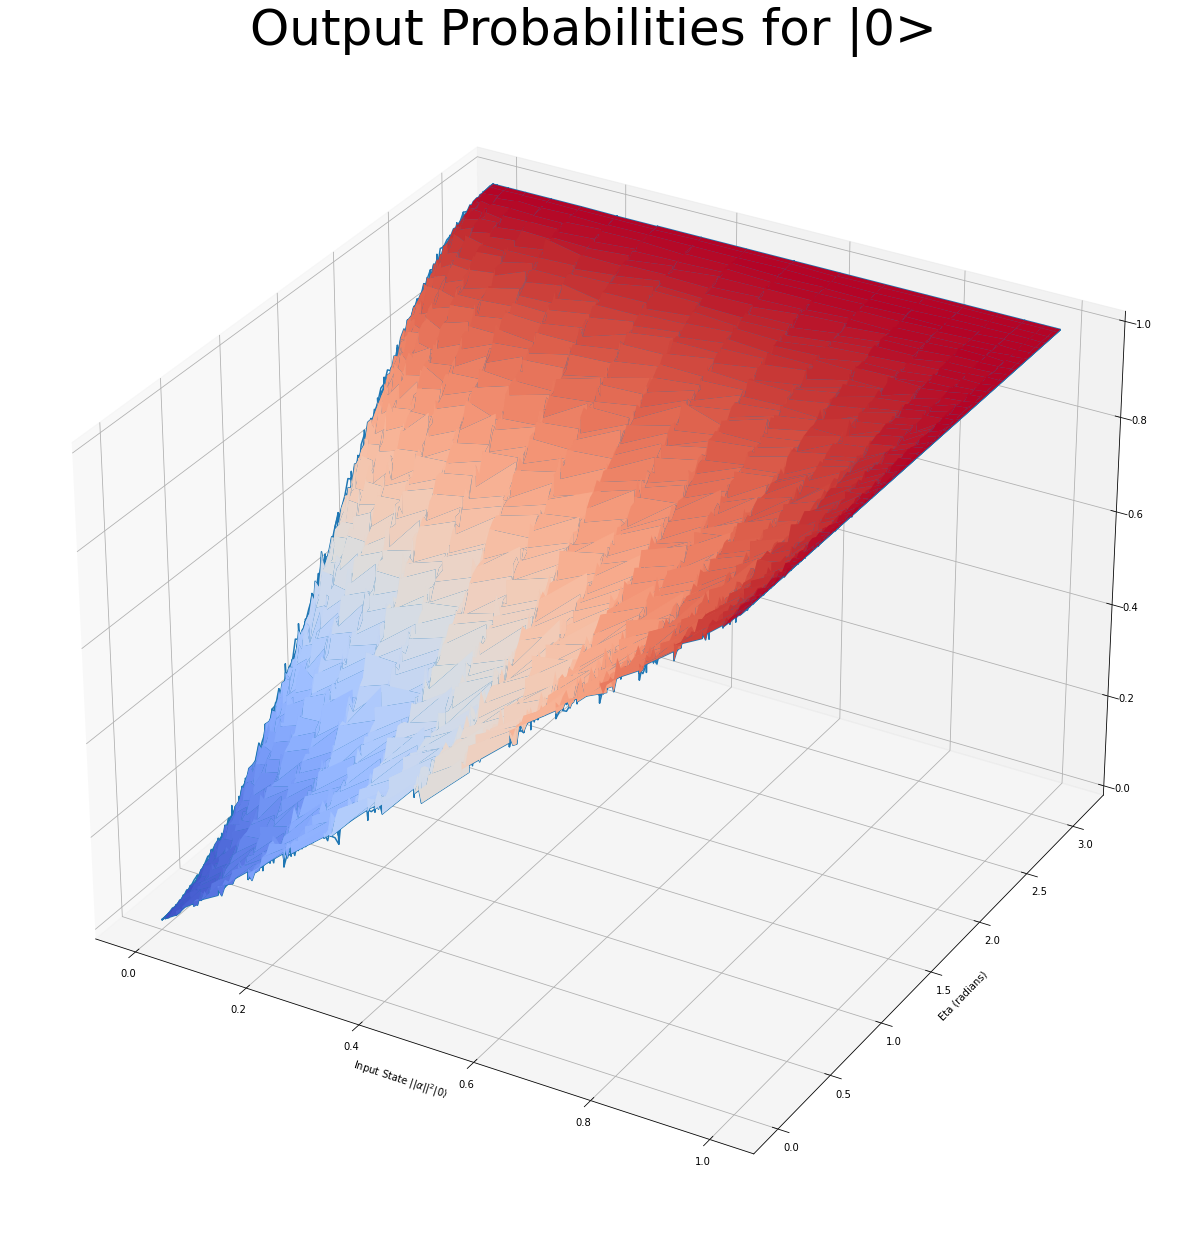

In [24]:
#Representation of output probabilities for all circuit in a 3d plot
fig = plt.figure(figsize=(100,125))
ax = fig.add_subplot(5,4,1, projection='3d')
ax.plot_wireframe(X_Input0, Y_Eta, Z_Output0, rstride=2, cstride=2)
ax.plot_surface(X_Input0, Y_Eta, Z_Output0, cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_title("Output Probabilities for |0>", fontsize=50)

plt.ylabel("Eta (radians)")
plt.xlabel("Input State ||" + "$\\alpha||^2 |0\\rangle$")

plt.show()

In [25]:
def plot_probabilities2(data_0, data_1, color, angle): 
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True)
    axs[0].set_ylabel("Probabilities")
    axs[0].grid(zorder=0.1)
    axs[0].bar(range(len(data_0)), data_0, color=color)
    axs[1].grid(zorder=0.1)
    axs[1].bar(range(len(data_1)), data_1, color=color)
    if angle=="None":
        fig.suptitle("Input States Probabilities for any " + "$\\eta" + " value", fontsize=50)
        axs[0].set_xlabel("Input " + "$\\alpha|0\\rangle$") 
        axs[1].set_xlabel("Input " + "$\\beta|1\\rangle$")
    else:
        fig.suptitle("Output States Probabilities for " + "$\eta=" + str(int(math.degrees(angle))) + "\degree$", fontsize=50)
        axs[0].set_xlabel("Output " + "$\\alpha|0\\rangle$")
        axs[1].set_xlabel("Output " + "$\\beta|1\\rangle$")

    
    fig.set_size_inches(15,5)
    display(plt.show())

In [26]:
#Print probabilities

# plot_probabilities2(X_Input0[0], X_Input1[0], "orange", "None")
# for index in range(len(anglesEta)):
 #   plot_probabilities2(Z_Output0[index], Z_Output1[index], "blue", anglesEta[index])


In [35]:
fig = plt.figure(figsize=(200,250))
ax = fig.add_subplot(5, 4, 1, projection='3d')
draw_cube(ax)

# draw initial states
surf = ax.plot_surface(initialStatesReshaped['reshapedCoordsX'], initialStatesReshaped['reshapedCoordsY'], initialStatesReshaped['reshapedCoordsZ'], cmap=cm.coolwarm, linewidth=0, antialiased=True)

# draw center
ax.scatter([0], [0], [0], color="g", s=50)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


ax.set_title("Initial States Bloch Sphere", fontsize=100)
ax.tick_params(axis = 'both', which = 'major', labelsize = 40)

display(plt.show())

IndexError: arrays used as indices must be of integer (or boolean) type

In [33]:
def plot_surface_blochs(initialStatesReshaped, allChannelsFinalStatesReshaped, anglesEta, rows=3, cols=3):
    fig = plt.figure(figsize=(20, 25))
    # ===============
    #  First subplot
    # ===============
    # set up the axes for the first plot
    ax = fig.add_subplot(rows, cols, 1, projection='3d')
    draw_cube(ax)

    # draw initial states
    surf = ax.plot_surface(initialStatesReshaped['reshapedCoordsX'],
                           initialStatesReshaped['reshapedCoordsY'], initialStatesReshaped['reshapedCoordsZ'], linewidth=0, antialiased=True)
    ax.set_title("Input States")
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # ===============
    # Next subplots
    # ===============

    indexFinalStateReshaped = 0
    modulus_number = np.round(len(allChannelsFinalStatesReshaped) / (rows * cols - 1))
    index_to_print = 0
    for finalStatesReshaped in allChannelsFinalStatesReshaped:
        if (indexFinalStateReshaped % modulus_number == 0 and index_to_print < (rows * cols - 1)):
            # set up the axes for the second plot
            ax = fig.add_subplot(rows, cols, 2 + index_to_print, projection='3d')
            draw_cube(ax)
            # draw final states
            surf = ax.plot_surface(finalStatesReshaped['reshapedCoordsX'],
                                   finalStatesReshaped['reshapedCoordsY'], finalStatesReshaped['reshapedCoordsZ'], linewidth=0, antialiased=True)
            title = "Output States\n Channel " + "$\eta=" + \
                str(int(math.degrees(anglesEta[indexFinalStateReshaped]))) + "\degree$"
            ax.set_title(title)
            fig.colorbar(surf, shrink=0.5, aspect=5)
            index_to_print += 1
        indexFinalStateReshaped += 1

    plt.show()

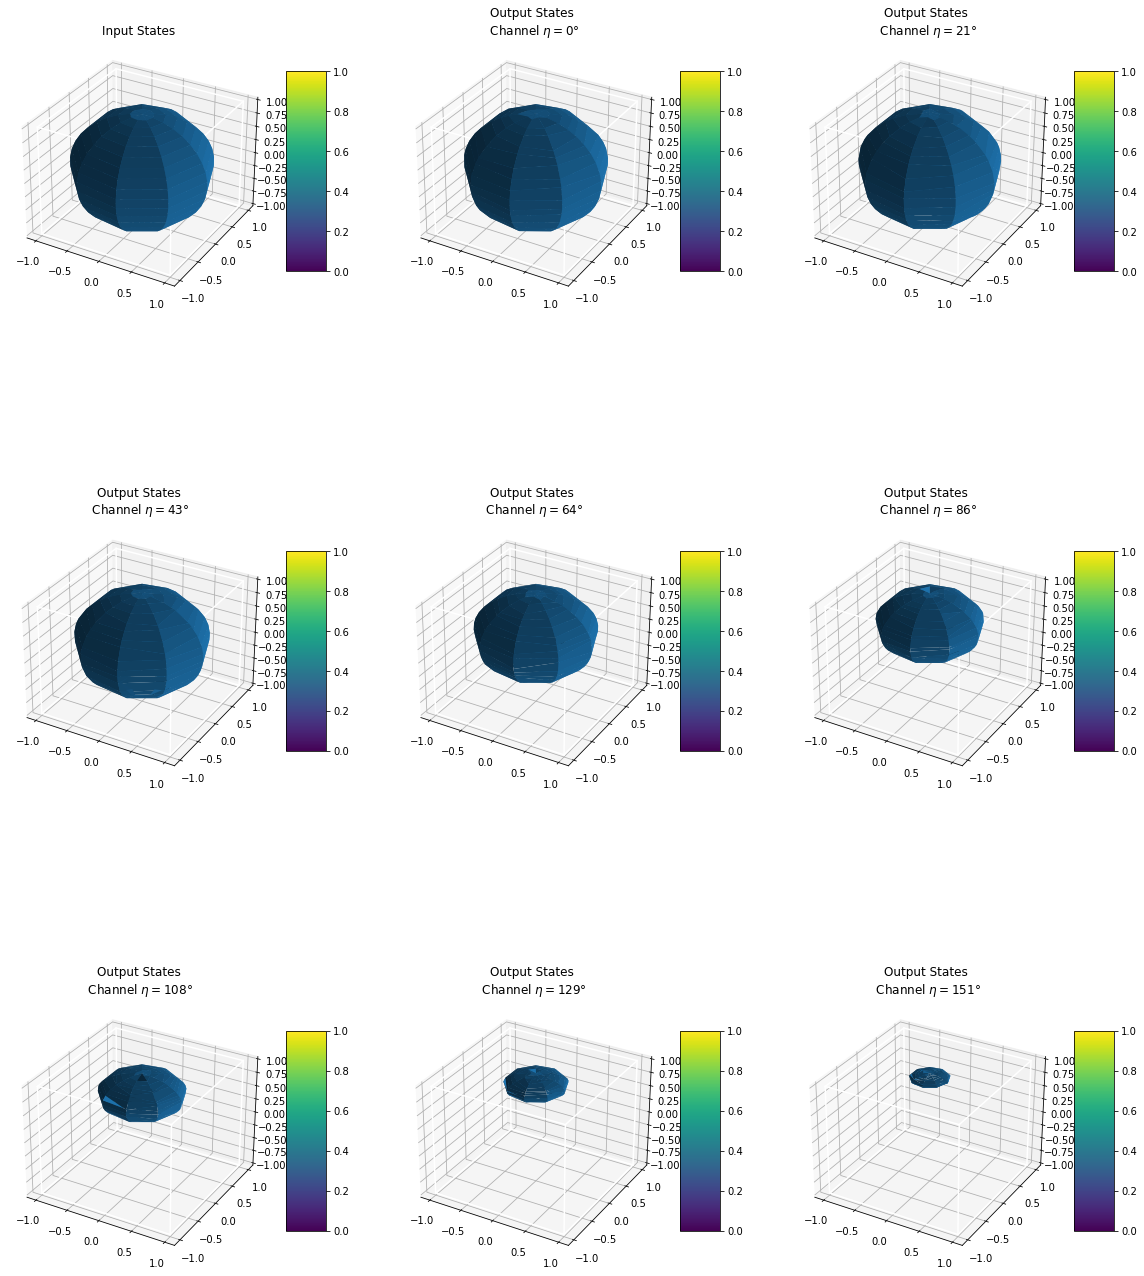

In [34]:
plot_surface_blochs(initialStatesReshaped, allChannelsFinalStatesReshaped, anglesEta, rows=3, cols=3)

### Fidelity of our damping channel for $\eta=\pi/4$

In [110]:
backend_sim = Aer.get_backend('statevector_simulator')
anglesTheta = np.mgrid[0:pi:pointsTheta*1j]
anglesPhase = np.mgrid[0:2*pi:pointsPhase*1j]

initialStates = prepareInitialStates(anglesTheta, anglesPhase)
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(1, 'c')
eta = pi/4
stavec = []
statevector = []
fidelity = []
for indexInitialState in range(len(initialStates["zeroAmplitude"])):
    circ = QuantumCircuit(qreg_q, creg_c)
    circ.initialize([initialStates["zeroAmplitude"][indexInitialState], initialStates["oneAmplitude"][indexInitialState]], qreg_q[0])
    circ.reset(qreg_q[1])
    res = execute(circ, backend_sim).result() 
    sv0 = result.get_statevector(circuit)
    print("iteracion=", indexInitialState)
    print("sv0=", sv0)
    print("estado_inicial=", initialStates["zeroAmplitude"][indexInitialState], initialStates["oneAmplitude"][indexInitialState])
    
#    stavec.append(sv0)

#    circuit = QuantumCircuit(qreg_q, creg_c)
#    circuit.initialize([initialStates["zeroAmplitude"][indexInitialState], initialStates["oneAmplitude"][indexInitialState]], qreg_q[0])
#    circuit.reset(qreg_q[1])
#    circuit.cry(eta, qreg_q[0], qreg_q[1])
#    circuit.cx(qreg_q[1], qreg_q[0])
#    circuit.measure(qreg_q[0], creg_c[0])
#    result = execute(circuit, backend_sim).result()
#    sv1 = result.get_statevector(circuit)
#    statevector.append(sv1)
#    fidelity.append(state_fidelity(sv0, sv1)) 

#count=0
#for i in range(len(initialStates["zeroAmplitude"])):
#    print("input=", stavec[i])
#    print("output=", statevector[i])  
#    print("fidelity= ", fidelity[i])
#     if fidelity[i] == 0.0:
#        print(i, "input=", stavec[i], "output=", statevector[i])
#        print("count", count)
#        count = count+1
#print(count)
#len(statevector)
#
#print(initialStates)

iteracion= 0
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (1+0j) 0j
iteracion= 1
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (1+0j) 0j
iteracion= 2
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (1+0j) 0j
iteracion= 3
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (1+0j) 0j
iteracion= 4
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (1+0j) 0j
iteracion= 5
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]


iteracion= 43
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.9458172417006346+0j) (-0.16234973460234164+0.28119798892657893j)
iteracion= 44
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.9458172417006346+0j) (-0.3051176951847423+0.11105375899515445j)
iteracion= 45
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.9458172417006346+0j) (-0.30511769518474235-0.11105375899515438j)
iteracion= 46
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.9458172417006346+0j) (-0.16234973460234187-0.2811979889265788j)
iteracion= 47
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j


iteracion= 85
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.7891405093963937+0j) (-0.5771711537073761-0.21007312002656794j)
iteracion= 86
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.7891405093963937+0j) (-0.3071063563448342-0.5319238125166048j)
iteracion= 87
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.7891405093963937+0j) (0.10665691825842245-0.6048814414554448j)
iteracion= 88
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.7891405093963937+0j) (0.4705142354489534-0.3948083214288769j)
iteracion= 89
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00

iteracion= 130
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.4759473930370736+0j) (0.8794737512064891+0j)
iteracion= 131
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.4759473930370736+0j) (0.6737159799807336+0.5653148303200732j)
iteracion= 132
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.4759473930370736+0j) (0.15271901420290618+0.8661125687588802j)
iteracion= 133
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.4759473930370736+0j) (-0.4397368756032443+0.7616466105064148j)
iteracion= 134
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0

iteracion= 174
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.16459459028073398+0j) (-0.9268764382363086+0.33735543436069265j)
iteracion= 175
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.16459459028073398+0j) (-0.9268764382363087-0.33735543436069243j)
iteracion= 176
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.16459459028073398+0j) (-0.4931806517013616-0.8542139460566875j)
iteracion= 177
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e-16j
  0.00000000e+00+0.0000000e+00j -1.66768924e-33+0.0000000e+00j]
estado_inicial= (0.16459459028073398+0j) (0.17127984285706055-0.9713762588622279j)
iteracion= 178
sv0= [ 0.00000000e+00+0.0000000e+00j  1.00000000e+00-2.4492936e

In [ ]:
    qreg_q = QuantumRegister(2, 'q')
    creg_c = ClassicalRegister(1, 'c')
    # First we generate the angles which will help the draw the sphere
    anglesTheta = np.mgrid[0:pi:pointsTheta*1j]
    anglesPhase = np.mgrid[0:2*pi:pointsPhase*1j]

    totalResults = []
    totalCounts = []
    totalCircuits = []
    totalFinalStates = []

    Z_Output0 = []
    Z_Output1 = []
    X_Input0 = []
    X_Input1 = []
    Y_Eta = []
    
    initialStates = prepareInitialStates(anglesTheta, anglesPhase)

    # Initialize circuit with desired initial_state
    for eta in anglesEta:
        print("Simulating channel with " + u"\u03B7" + " = " + str(int(math.degrees(eta)))  + u"\u00B0")
        circuitResultsSpecificChannel = []
        countsSpecificChannel = []
        circuitSpecificChannel = []
        finalStates = {
            "zeroAmplitude": [],
            "oneAmplitude": [],
        }
        
        nested_Z_Output0 = []
        nested_Z_Output1 = []
        nested_X_Input0 = []
        nested_X_Input1 = []
        nested_Y_Eta = []
        Z_Output0.append(nested_Z_Output0)
        Z_Output1.append(nested_Z_Output1)
        X_Input0.append(nested_X_Input0)
        X_Input1.append(nested_X_Input1)
        Y_Eta.append(nested_Y_Eta)
        loop_counter = 0
        
        for indexInitialState in range(len(initialStates["zeroAmplitude"])):
                phase_cycle=indexInitialState//(len(anglesPhase)*len(anglesTheta))
                if loop_counter < phase_cycle:
                    loop_counter = phase_cycle
                    nested_Z_Output0 = []
                    nested_Z_Output1 = []
                    nested_X_Input0 = []
                    nested_X_Input1 = []
                    nested_Y_Eta = []
                    
                circuit = QuantumCircuit(qreg_q, creg_c)
                circuit.initialize([initialStates["zeroAmplitude"][indexInitialState], initialStates["oneAmplitude"][indexInitialState]], qreg_q[0])

                circuit.reset(qreg_q[1])
                circuit.cry(eta, qreg_q[0], qreg_q[1])
                circuit.cx(qreg_q[1], qreg_q[0])
                circuit.measure(qreg_q[0], creg_c[0])
                circuitSpecificChannel.append(circuit)
                # execute circuit on backends
                job_sim = execute(circuit, backend, shots=iterations)
                # get results
                results_sim = job_sim.result()
                circuitResultsSpecificChannel.append(results_sim)
                counts = results_sim.get_counts(circuit)
                countsSpecificChannel.append(counts)
                finalState = convertCountsToFinalState(counts)
                finalStates["zeroAmplitude"].append(finalState["zeroAmplitude"])
                finalStates["oneAmplitude"].append(finalState["oneAmplitude"])
                nested_Z_Output0.append(finalState["zeroAmplitude"]**2)
                nested_Z_Output1.append(finalState["oneAmplitude"]**2)
                Prob_0 = initialStates["zeroAmplitude"][indexInitialState]*np.conj(initialStates["zeroAmplitude"][indexInitialState])
                Prob_1 = initialStates["oneAmplitude"][indexInitialState]*np.conj(initialStates["oneAmplitude"][indexInitialState])
                nested_X_Input0.append(Prob_0.real)
                nested_X_Input1.append(Prob_1.real)
                nested_Y_Eta.append(eta)
            
            # append the results for a specific channel
        totalCircuits.append(circuitSpecificChannel)
        totalFinalStates.append(finalStates)
        totalCounts.append(countsSpecificChannel)
        totalResults.append(circuitResultsSpecificChannel)

    return {
        "initialStates": initialStates,
        "totalCircuits": totalCircuits,
        "totalFinalStates": totalFinalStates,
        "totalCounts": totalCounts,
        "totalResults": totalResults,
        "anglesPhase": anglesPhase,
        "Z_Output0": np.array(Z_Output0),
        "Z_Output1": np.array(Z_Output1),
        "X_Input0": np.array(X_Input0),
        "X_Input1": np.array(X_Input1),
        "Y_Eta": np.array(Y_Eta)

     ┌─────────────────┐           ┌───┐┌─┐
q_0: ┤ initialize(1,0) ├─────■─────┤ X ├┤M├
     └─────────────────┘┌────┴────┐└─┬─┘└╥┘
q_1: ────────|0>────────┤ RY(π/4) ├──■───╫─
                        └─────────┘      ║ 
c: 1/════════════════════════════════════╩═
                                         0 
[[0.8987 0.2502]
 [0.1013 0.7498]]


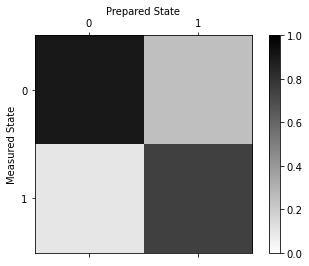

Average Measurement Fidelity: 0.824250


ZeroDivisionError: division by zero

In [61]:
qubit_list = [0]
print(totalCircuits[25][0])
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=totalCircuits[25][0].qregs[0], circlabel='mcal')
# Execute the calibration circuits without noise
#backend = Aer.get_backend('qasm_simulator')
#job = execute(meas_calibs, backend=backend, shots=1000)
#cal_results = job.result()
#meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
#print(Matrix without noise)
#print(meas_fitter.cal_matrix)

# Generate a noise model for the qubits
noise_model = noise.NoiseModel()
for qi in range(1):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])
# Execute the calibration circuits
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=10000, noise_model=noise_model)
cal_results = job.result()
# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)
# Plot the calibration matrix
meas_fitter.plot_calibration()
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

# What is the measurement fidelity of Q0?
print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
    label_list = [['000','001','010','011'],['100','101','110','111']]))

In [49]:
state_labels

['0', '1']

### Plotting both Initial States and Final States for all simulated 16 channels

In [4]:
def plotChannelsBlochs():
    fig = plt.figure(figsize=(20,50))
    #===============
    #  First subplot
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(26, 4, 1, projection='3d')
    draw_cube(ax)

    # draw initial states
    ax.plot_wireframe(initialStatesReshaped['reshapedCoordsX'], initialStatesReshaped['reshapedCoordsY'], initialStatesReshaped['reshapedCoordsZ'], color="c")
    ax.set_title("Initial States")
    # draw center
    ax.scatter([0], [0], [0], color="g", s=50)

    #===============
    # Next subplots
    #===============

    indexFinalStateReshaped = 0
    for finalStatesReshaped in allChannelsFinalStatesReshaped:
        # set up the axes for the second plot
        ax = fig.add_subplot(26, 4, 2 + indexFinalStateReshaped, projection='3d')
        draw_cube(ax)
        # draw final states
        ax.plot_wireframe(finalStatesReshaped['reshapedCoordsX'], finalStatesReshaped['reshapedCoordsY'], finalStatesReshaped['reshapedCoordsZ'], color="r")
        title = "Final States\n Channel " + "$\eta=" + str(int(math.degrees(anglesEta[indexFinalStateReshaped]))) + "\degree$"
        ax.set_title(title)
        # draw center
        ax.scatter([0], [0], finalStatesReshaped["center"], color="g", s=50)
        indexFinalStateReshaped+=1



    display(plt.show())

In [3]:
# plotChannelsBlochs()

In [27]:
# plotChannelsBlochs()